In [1]:
import os
import random
import itertools

# 基本的なライブラリ
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats

# 描画ライブラリ
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn_analyzer import CustomPairPlot
import graphviz
import pydotplus
from IPython.display import Image
from IPython.display import HTML
from six import StringIO
from ipywidgets import interact, FloatSlider

# データセット分割
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.experimental import (
    enable_iterative_imputer,
)  # IterativeImputerをimportするために必要
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer

# 前処理
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE

# 特徴量選択
from sklearn.feature_selection import (
    SequentialFeatureSelector,
    VarianceThreshold,
    RFE,
    RFECV,
)


# 学習中
from tqdm import tqdm
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings


# config python file
import config

SEED = config.SEED


from functions import *

fix_seed(SEED)


# 最大表示列数の指定（ここでは50列を指定）N
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 50)

%matplotlib inline

/Users/masanari/Library/CloudStorage/OneDrive-東京理科大学/projects/breast_cancer_analytics/notebooks/functions.py:257: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y: pd.Series(),


# データ読み込み

In [2]:
df_patient = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR + "/data_clinical_patient.txt", header=4
)
df_sample = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR + "/data_clinical_sample.txt", header=4
)

In [3]:
df_patient.shape, df_sample.shape

((2509, 24), (2509, 13))

In [4]:
df_clinical = pd.merge(df_patient, df_sample, on="PATIENT_ID")
check(df_clinical)

,feature,dtypes,nan,count,max,min,num_unique,unique,unique_counts
0,PATIENT_ID,object,0,2509,nan,nan,2509,,
1,LYMPH_NODES_EXAMINED_POSITIVE,float64,266,2243,45.000000,0.000000,32,,
2,NPI,float64,222,2287,7.200000,1.000000,436,,
3,CELLULARITY,object,592,1917,nan,nan,3,[nan 'High' 'Moderate' 'Low'],"{'High': 965, 'Moderate': 737, 'Low': 215}"
4,CHEMOTHERAPY,object,529,1980,nan,nan,2,['NO' 'YES' nan],"{'NO': 1568, 'YES': 412}"
5,COHORT,float64,11,2498,9.000000,1.000000,9,[ 1. 2. 3. 5. 4. 9. 7. 6. nan 8.],"{1.0: 809, 3.0: 763, 2.0: 288, 4.0: 238, 5.0: 170, 7.0: 105, 8.0: 82, 9.0: 40, 6.0: 3}"
6,ER_IHC,object,83,2426,nan,nan,2,['Positve' 'Negative' nan],"{'Positve': 1817, 'Negative': 609}"
7,HER2_SNP6,object,529,1980,nan,nan,4,['NEUTRAL' 'LOSS' nan 'GAIN' 'UNDEF'],"{'NEUTRAL': 1436, 'GAIN': 438, 'LOSS': 101, 'UNDEF': 5}"
8,HORMONE_THERAPY,object,529,1980,nan,nan,2,['YES' 'NO' nan],"{'YES': 1216, 'NO': 764}"
9,INFERRED_MENOPAUSAL_STATE,object,529,1980,nan,nan,2,['Post' 'Pre' nan],"{'Post': 1556, 'Pre': 424}"


## カラムの順序変更（読みやすさのため）

In [5]:
def align_columns(df: pd.DataFrame, regex: str):
    # まとめたいcolumnの正規表現を一時退避
    df_copy = df.copy()
    df_tmp = df_copy.filter(regex=regex)
    # 元のdfから落とす
    df_copy.drop(df_tmp.columns, axis=1, inplace=True)
    # 元のdfに結合
    return pd.merge(df_copy, df_tmp, right_index=True, left_index=True)

In [6]:
# 癌の種類
df_clinical = align_columns(df_clinical, "^CANCER_")
# 重要そう（直感）な特徴量
df_clinical = align_columns(df_clinical, "^ER_|^HER2_|^TUMOR_")
# 治療の種類
df_clinical = align_columns(df_clinical, ".*THERAPY$|^BREAST_SURGERY")
# target系の種類（OS, RFS, VITAL）
df_clinical = align_columns(df_clinical, "^OS_.*|^RFS_.*|^VITAL_.*")

check(df_clinical)

,feature,dtypes,nan,count,max,min,num_unique,unique,unique_counts
0,PATIENT_ID,object,0,2509,nan,nan,2509,,
1,LYMPH_NODES_EXAMINED_POSITIVE,float64,266,2243,45.000000,0.000000,32,,
2,NPI,float64,222,2287,7.200000,1.000000,436,,
3,CELLULARITY,object,592,1917,nan,nan,3,[nan 'High' 'Moderate' 'Low'],"{'High': 965, 'Moderate': 737, 'Low': 215}"
4,COHORT,float64,11,2498,9.000000,1.000000,9,[ 1. 2. 3. 5. 4. 9. 7. 6. nan 8.],"{1.0: 809, 3.0: 763, 2.0: 288, 4.0: 238, 5.0: 170, 7.0: 105, 8.0: 82, 9.0: 40, 6.0: 3}"
5,INFERRED_MENOPAUSAL_STATE,object,529,1980,nan,nan,2,['Post' 'Pre' nan],"{'Post': 1556, 'Pre': 424}"
6,SEX,object,0,2509,nan,nan,1,['Female'],{'Female': 2509}
7,INTCLUST,object,529,1980,nan,nan,11,['4ER+' '3' '9' '7' '4ER-' nan '5' '8' '10' '1' '2' '6'],"{'8': 299, '3': 290, '4ER+': 260, '10': 226, '7': 190, '5': 190, '9': 146, '1': 139, '6': 85, '4ER-': 83, '2': 72}"
8,AGE_AT_DIAGNOSIS,float64,11,2498,96.290000,21.930000,1843,,
9,CLAUDIN_SUBTYPE,object,529,1980,nan,nan,7,['claudin-low' 'LumA' 'LumB' 'Normal' nan 'Her2' 'Basal' 'NC'],"{'LumA': 700, 'LumB': 475, 'Her2': 224, 'claudin-low': 218, 'Basal': 209, 'Normal': 148, 'NC': 6}"


In [7]:
# データの型の定義（適用する前処理が大きく異なるため）

int_columns = [
    # patient
    "LYMPH_NODES_EXAMINED_POSITIVE",
    "OS_MONTHS",
    "RFS_MONTHS",
]

float_columns = [
    # patient
    "NPI",
    "AGE_AT_DIAGNOSIS",
    # sample
    "TUMOR_SIZE",
    "TMB_NONSYNONYMOUS",
]

str_columns = []

# 質的変数（順序尺度）
num_cat_columns = [
    # patient
    "CELLULARITY",
    "ER_IHC",
    "HER2_SNP6",
    "INFERRED_MENOPAUSAL_STATE",
    # sample
    "ER_STATUS",
    "HER2_STATUS",
    "GRADE",
    "PR_STATUS",
    "TUMOR_STAGE",
]
# 質的変数（名義尺度）
str_cat_columns = [
    # patient
    "COHORT",
    "INTCLUST",
    "CLAUDIN_SUBTYPE",
    "THREEGENE",
    "HISTOLOGICAL_SUBTYPE",
    "BREAST_SURGERY",
    "LATERALITY",
    "VITAL_STATUS",
    # sample
    "CANCER_TYPE",
    "CANCER_TYPE_DETAILED",
    "ONCOTREE_CODE",
]

bool_columns = [
    # patient
    "CHEMOTHERAPY",
    "HORMONE_THERAPY",
    "RADIO_THERAPY",
    "OS_STATUS",
    "RFS_STATUS",
]

meanless_columns = [
    # patient
    "PATIENT_ID",
    "SEX",
    # sample
    #'PATIENT_ID',
    "SAMPLE_ID",
    "SAMPLE_TYPE",
]

print(
    df_clinical.shape[1],
    len(int_columns)
    + len(float_columns)
    + len(str_columns)
    + len(num_cat_columns)
    + len(str_cat_columns)
    + len(bool_columns)
    + len(meanless_columns),
)
assert df_clinical.shape[1] == len(int_columns) + len(float_columns) + len(
    str_columns
) + len(num_cat_columns) + len(str_cat_columns) + len(bool_columns) + len(
    meanless_columns
), "lack or too much columns"

36 36


In [8]:
# データを大きく2つに分割できるので、ここで分割
df_MB = df_clinical[df_clinical["PATIENT_ID"].str.contains("MB")]
df_MTST = df_clinical[df_clinical["PATIENT_ID"].str.contains("MTS-T")]
df_MB.shape, df_MTST.shape

((1985, 36), (524, 36))

In [9]:
# save
make_dir(config.INTERIM_PICKLE_EDA_DIR)
df_clinical.to_pickle(config.INTERIM_PICKLE_EDA_DIR + "/df_clinical.pkl")
df_MB.to_pickle(config.INTERIM_PICKLE_EDA_DIR + "/df_MB.pkl")
df_MTST.to_pickle(config.INTERIM_PICKLE_EDA_DIR + "/df_MTST.pkl")

# OS_MONTHSとRFS_MONTHSの確認

秋本先生によると、どちらも「診察結果、乳がんと判明」したときからの時間らしい  
- OS_MONTHS：生存期間▷乳がんと診察されてからの生存期間
- RFS_MONTHS：再発期間▷乳がんと診断されてからの再発までの期間

これらを確認していく

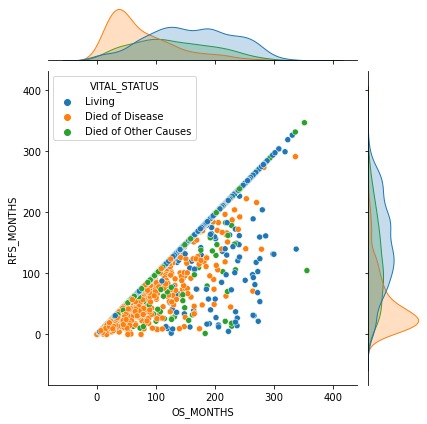

In [10]:
sns.jointplot(x="OS_MONTHS", y="RFS_MONTHS", data=df_MB, hue=df_MB.VITAL_STATUS)
plt.show()

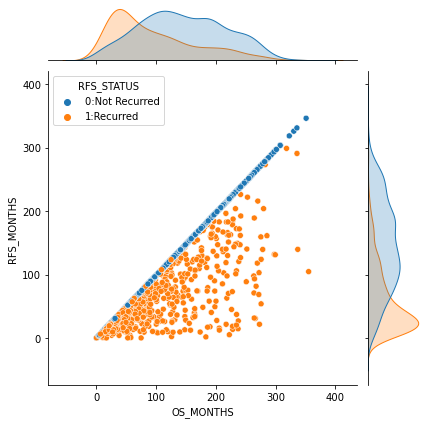

In [11]:
# OS_MONTHSとRFS_MONTHSのサイズの確認
# 定義通りであれば、OS_MONTHS>=RFS_MONTHSであることが可視化される
sns.jointplot(x="OS_MONTHS", y="RFS_MONTHS", data=df_MB, hue=df_MB.RFS_STATUS)
plt.show()

In [12]:
print(len(df_MB))  # サンプル数
# 定義に反したデータがないかの確認
print((df_MB.OS_MONTHS < df_MB.RFS_MONTHS).sum())  # OS_MONTHS<RFS_MONTHSとなるサンプル数
print((df_MB.OS_MONTHS == df_MB.RFS_MONTHS).sum())  # OS_MONTHS==RFS_MONTHSとなるサンプル数

1985
0
2


OS_MONTHS >= RFS_MONTHSであるため、秋本先生から伺った定義は正しいと考えて良さそう

In [13]:
df_MB[(df_MB.OS_MONTHS == df_MB.RFS_MONTHS)][
    ["PATIENT_ID", "OS_MONTHS", "RFS_MONTHS", "VITAL_STATUS", "RFS_STATUS"]
]

,PATIENT_ID,OS_MONTHS,RFS_MONTHS,VITAL_STATUS,RFS_STATUS
186,MB-0284,0.0,0.0,Living,0:Not Recurred
1694,MB-6229,0.1,0.1,Died of Disease,1:Recurred


この2件はなんなのだろうか？  
特にMB-6229が再発期間も短く不明である

# 目的変数の生成

元のdfにはない目的変数カラム（5年後の生存の有無）を生成する。

## 目的変数｜5,10,15年後の予後の2値分類
5,10,15年後の予後を2値分類する。  
そのためにVITAL_STATUSとOS_MONTHを利用する。  
以下のフローチャートで生成する。  

In [14]:
HTML(
    '<div class="mxgraph" style="max-width:100%;border:1px solid transparent;" data-mxgraph="{&quot;highlight&quot;:&quot;#0000ff&quot;,&quot;nav&quot;:true,&quot;resize&quot;:true,&quot;toolbar&quot;:&quot;zoom layers tags lightbox&quot;,&quot;edit&quot;:&quot;_blank&quot;,&quot;xml&quot;:&quot;&lt;mxfile host=\&quot;Electron\&quot; modified=\&quot;2022-05-01T07:33:42.0.405Z\&quot; agent=\&quot;5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) draw.io/17.2.0.2 Chrome/100.0.4896.60 Electron/18.0.1 Safari/537.36\&quot; etag=\&quot;CUa6MuG2A-EYqdbBh0ys\&quot; version=\&quot;17.2.0.2\&quot; type=\&quot;device\&quot;&gt;&lt;diagram id=\&quot;C5RBs43oDa-KdzZeNtuy\&quot; name=\&quot;Page-1\&quot;&gt;7VhZc5swEP41TJ7a4Yix/RjbcZI2SduBJNOnjAIyqBasK4SP/vpKQTIQXB9tncMTP3jYZVlJ+317gOH0k/kZQ5P4CkJMDdsM54YzMGy7ZZniXyoWhcLtOoUiYiQsVFap8MgvrJTquSgnIc5qhhyAcjKpKwNIUxzwmg4xBrO62QhofdUJinBD4QWINrV3JORxoe3Y7VJ/jkkU65Utt1vcSZA2VifJYhTCrKJyTg2nzwB4cZXM+5jK2Om43F0s7ujl2D379C37iW56n/3r2w+Fs+EujyyPwHDK/69ru3A9RTRX8VJn5QsdQAZ5GmLpxDScXswTKi4tcfkDc75QgKOcg1AB4zFEkCJ6CTBRdiNIuTKzpIzT8EQCK+QHCsG4UA0JpWoNISn7jpAyzmC8xE46WAIhjSl6wLSHgnH0uNE+UGDiVgoplq5CQQZ1lnJzp6W2t2VsFQYZ5CzAa+xUcnDEIrzOn1vYyf1VeKqQO8OQYM4WwoBhijiZ1smMVE5ES7sSd3GhoN+BBk6DBuHIaPVuL/yTy3vPP/FvPMMWrs0v3v3Vl2v/3DNagzVMkSjNYsKxN0GP4ZqJ2lJnT5UV4uC9iKIsU5hugHw3yKaYcTxfG2R911WZrkpdR4mzsm5YuhjElZpxbO4JluMGLN9FKX1P0H9JUHfLBNX9a2OGKrJoYmydsMrTVyDiXKUJjEaZ2NhT6iwX/Hs2tRpsuoYGmTbj8abp9kJkau/GJevVc8ltcKnsDDITXJTIek+5jLm8b+raWi1cMSQPeba5V9QAlvQZooRQGaxzTKeYkwCt6CiIkigVQiCwxmw1c8SSJI2E5JaS/8hUUXz32Gna9U6zlKutxlzRajr7ajXt1ROAYrZs9maB4xDRDB9c63fsJ4B0X7r3d7ap1m+6Fj9769dldXPvt7as14o95kdH/GoEev3jQHer4fJ9HtgPw+xDmwj0Dit8qr8+qv5xNCCCLLYJI/E3IBlGGT56Hw3+OBrYqzrRs44GuhpWZwMmAnFoM8DT1/9j56VnAF0lNk9lPssPfyhzrP0BIsTyS25RE8vP4c7pbw==&lt;/diagram&gt;&lt;/mxfile&gt;&quot;}"></div><script type="text/javascript" src="https://viewer.diagrams.net/js/viewer-static.min.js"></script>'
)

In [95]:
def make_target(df: pd.DataFrame(), year: int = 5):
    df = df.copy()  # 引数dfの更新を防ぐ（pythonの関数は参照渡し）
    target_name = "OS_" + str(year) + "years"
    df[target_name] = np.nan
    df[target_name] = df[target_name].mask(df["OS_MONTHS"] > year * 12, False)
    df[target_name] = df[target_name].mask(
        (df["OS_MONTHS"] <= year * 12) & (df["VITAL_STATUS"] == "Died of Disease"),
        True,
    )
    # targetを定義できなかったデータは除く
    df = df[df[target_name].notnull()]
    return df

In [96]:
df_os_5 = make_target(df_MB, year=5)
df_os_10 = make_target(df_MB, year=10)
df_os_15 = make_target(df_MB, year=15)

dict_df_os = {
    "df_os_5": df_os_5.copy(),
    "df_os_10": df_os_10.copy(),
    "df_os_15": df_os_15.copy(),
}

for column in ["OS_STATUS", "VITAL_STATUS"]:
    for d in dict_df_os.values():
        if column in d:
            d.drop(column, axis=1, inplace=True)

if "VITAL_STATUS" in str_cat_columns:
    str_cat_columns.remove("VITAL_STATUS")
if "OS_STATUS" in bool_columns:
    bool_columns.remove("OS_STATUS")

In [97]:
dict_df_os["df_os_5"].shape, dict_df_os["df_os_10"].shape, dict_df_os["df_os_15"].shape

((1827, 35), (1469, 35), (1121, 35))

# 特徴量全体の関係の確認

## クラスターマップの作成

seabornのクラスターマップの引数のdfはnullを持てないので、行・列を削除する

In [98]:
# データの総量5%以下のnull値は補完せずに削除する


def dropna_nper(df_original: pd.DataFrame(), percent: int = 0.05):
    df = df_original.copy()
    # nullを含むデータのインデックスを確認
    num = int(df.shape[0] * percent)
    print("除外データ数：", str(num))
    # df_MB[df_MB.isnull().any(axis=1)]
    # nullを含むデータ数がnum個以下のcolumnsを抽出（indexとなっているのはisnull().sum()で取り出した際、indexにcolumns名が来るため）
    columns_u5null = df.isnull().sum()[df.isnull().sum() < num].index
    df_u5null = df[columns_u5null]
    # nullを含むデータ数がnum個以下のデータの全てのindex
    index_u5null = df_u5null[df_u5null.isnull().any(axis=1)].index
    print("nullを含むデータ数がnum個以下のcolumnsを保有するデータのインデックス：", index_u5null)

    # nullを含むデータ数がnum個以下のcolumnsがなくなったか確認
    df.drop(index_u5null, inplace=True)
    return df

### 特徴量削除

#### 意味のない特徴量の削除


In [99]:
for column in meanless_columns:
    for d in dict_df_os.values():
        if column in d:
            d.drop(column, axis=1, inplace=True)

In [100]:
dict_df_os["df_os_5"].shape, dict_df_os["df_os_10"].shape, dict_df_os["df_os_15"].shape

((1827, 31), (1469, 31), (1121, 31))

#### リストワイズ法適用下で欠損値を保有する特徴量
欠損値がサンプル数の5%以上を占めている特徴量

- THREEGENE
- LATERALITY
- TUMOR_STAGE


In [101]:
for column in ["THREEGENE", "LATERALITY", "TUMOR_STAGE"]:
    for d in dict_df_os.values():
        if column in d:
            d.drop(column, axis=1, inplace=True)
# columnsのlistから上記の名前を削除
if "THREEGENE" in str_cat_columns:
    str_cat_columns.remove("THREEGENE")
if "LATERALITY" in str_cat_columns:
    str_cat_columns.remove("LATERALITY")
if "TUMOR_STAGE" in num_cat_columns:
    num_cat_columns.remove("TUMOR_STAGE")

#### 欠損値がサンプル数の5%以下の特徴量に対し、欠損値を持つサンプルの削除

In [102]:
dict_df_os["df_os_5"].shape, dict_df_os["df_os_10"].shape, dict_df_os["df_os_15"].shape

((1827, 28), (1469, 28), (1121, 28))

In [103]:
for k in dict_df_os:
    dict_df_os[k] = dropna_nper(dict_df_os[k])

除外データ数： 91
nullを含むデータ数がnum個以下のcolumnsを保有するデータのインデックス： Int64Index([   0,    7,   21,   27,   34,   41,   42,   58,   81,   86,
            ...
            1867, 1870, 1871, 1876, 1899, 1906, 1918, 1923, 1933, 1938],
           dtype='int64', length=244)
除外データ数： 73
nullを含むデータ数がnum個以下のcolumnsを保有するデータのインデックス： Int64Index([   0,    7,   21,   27,   34,   42,   58,   81,   86,   88,
            ...
            1860, 1867, 1870, 1871, 1876, 1899, 1906, 1918, 1933, 1938],
           dtype='int64', length=187)
除外データ数： 56
nullを含むデータ数がnum個以下のcolumnsを保有するデータのインデックス： Int64Index([   7,   34,   86,  110,  137,  145,  155,  166,  171,  174,
            ...
            1695, 1699, 1714, 1745, 1839, 1876, 1906, 1918, 1933, 1938],
           dtype='int64', length=138)


In [104]:
dict_df_os["df_os_5"].shape, dict_df_os["df_os_10"].shape, dict_df_os["df_os_15"].shape

((1583, 28), (1282, 28), (983, 28))

### 特徴量のエンコーディング

####　順序特徴量のエンコード（手動）

In [105]:
def encode_dtypes(df: pd.DataFrame()):
    df = df.copy()
    # cat
    df["CELLULARITY"] = (
        df["CELLULARITY"].replace({"High": 3, "Moderate": 2, "Low": 1}).astype(int)
    )
    df["ER_IHC"] = df["ER_IHC"].replace({"Positve": 1, "Negative": 0}).astype(int)
    df["HER2_SNP6"] = (
        df["HER2_SNP6"]
        .replace({"GAIN": 3, "NEUTRAL": 2, "LOSS": 1, "UNDEF": 0})
        .astype(int)
    )
    df["INFERRED_MENOPAUSAL_STATE"] = (
        df["INFERRED_MENOPAUSAL_STATE"].replace({"Post": 1, "Pre": 0}).astype(int)
    )
    df["ER_STATUS"] = (
        df["ER_STATUS"].replace({"Positive": 1, "Negative": 0}).astype(int)
    )
    df["HER2_STATUS"] = (
        df["HER2_STATUS"].replace({"Positive": 1, "Negative": 0}).astype(int)
    )
    df["GRADE"] = df["GRADE"].astype(int)
    df["PR_STATUS"] = (
        df["PR_STATUS"].replace({"Positive": 1, "Negative": 0}).astype(int)
    )
    # bool
    df["CHEMOTHERAPY"] = df["CHEMOTHERAPY"].replace({"YES": 1, "NO": 0}).astype(int)
    df["HORMONE_THERAPY"] = (
        df["HORMONE_THERAPY"].replace({"YES": 1, "NO": 0}).astype(int)
    )
    df["RADIO_THERAPY"] = df["RADIO_THERAPY"].replace({"YES": 1, "NO": 0}).astype(int)
    df["RFS_STATUS"] = (
        df["RFS_STATUS"].replace({"1:Recurred": 1, "0:Not Recurred": 0}).astype(int)
    )
    return df

#### Ordinal encoding
カテゴリ特徴量のエンコード（自動）
クラスター図（デンドログラム）の表示では、カテゴリ変数をそのまま入れることはできないようなので、カテゴリ変数をエンコードして数値変換する

In [106]:
def ordinal_encode(df: pd.DataFrame(), encoding_columns: list()):
    # init encoder
    ordinal_encoder = OrdinalEncoder()

    ordinal_encoded = ordinal_encoder.fit(df[encoding_columns])
    df_ordinal = pd.DataFrame(
        ordinal_encoder.transform(df[encoding_columns]),
        columns=ordinal_encoder.get_feature_names_out(encoding_columns),
    )
    df_ordinal = df_ordinal.astype(int)
    print(ordinal_encoded)
    check(df_ordinal)
    return df_ordinal

#### 元のdfとlabel encodeしたdfの結合

In [107]:
for k in dict_df_os:
    dict_df_os[k] = encode_dtypes(dict_df_os[k])
    dict_df_os[k] = pd.merge(
        # インデックスを参照してmergeするが、サンプルの削除によってインデックスがずれている
        # そのため、インデックスをここでリセットする
        dict_df_os[k].reset_index(drop=True).drop(str_cat_columns, axis=True),
        # Ordinal Encoderによって返るdf
        ordinal_encode(dict_df_os[k], str_cat_columns),
        right_index=True,
        left_index=True,
    )

OrdinalEncoder()
OrdinalEncoder()
OrdinalEncoder()


In [108]:
dict_df_os["df_os_5"].shape, dict_df_os["df_os_10"].shape, dict_df_os["df_os_15"].shape

((1583, 28), (1282, 28), (983, 28))

In [112]:
dict_df_os["df_os_5"]

,LYMPH_NODES_EXAMINED_POSITIVE,NPI,CELLULARITY,INFERRED_MENOPAUSAL_STATE,AGE_AT_DIAGNOSIS,GRADE,PR_STATUS,TMB_NONSYNONYMOUS,ER_IHC,HER2_SNP6,ER_STATUS,HER2_STATUS,TUMOR_SIZE,CHEMOTHERAPY,HORMONE_THERAPY,RADIO_THERAPY,OS_MONTHS,RFS_STATUS,RFS_MONTHS,OS_5years,COHORT,INTCLUST,CLAUDIN_SUBTYPE,HISTOLOGICAL_SUBTYPE,BREAST_SURGERY,CANCER_TYPE,CANCER_TYPE_DETAILED,ONCOTREE_CODE
0,0.0,4.020,3,0,43.19,3,1,2.615035,1,2,1,0,10.0,0,1,1,84.633333,0,83.52,False,0,4,2,0,0,0,1,1
1,1.0,4.030,3,0,48.87,2,1,2.615035,1,2,1,0,15.0,1,1,0,163.700000,1,151.28,False,0,3,3,0,1,0,1,1
2,3.0,4.050,2,0,47.68,2,1,1.307518,1,2,1,0,25.0,1,1,1,164.933333,0,162.76,False,0,10,3,3,1,0,4,4
3,8.0,6.080,3,1,76.97,3,1,2.615035,1,2,1,0,40.0,1,1,1,41.366667,1,18.55,True,0,10,3,3,1,0,4,4
4,0.0,4.062,2,1,78.77,3,1,5.230071,1,2,1,0,31.0,0,1,1,7.800000,1,2.89,True,0,8,3,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1578,1.0,5.050,3,0,43.10,3,1,5.230071,1,2,1,0,25.0,0,1,1,196.866667,0,194.28,False,3,3,2,1,0,0,2,2
1579,1.0,5.040,3,0,42.88,3,0,7.845106,1,3,1,1,20.0,0,0,1,44.733333,1,16.09,True,3,6,3,0,1,0,1,1
1580,45.0,6.050,3,1,62.90,3,1,5.230071,1,2,1,0,25.0,0,1,1,175.966667,1,121.18,False,3,0,3,0,1,0,1,1
1581,12.0,5.050,2,1,61.16,2,1,19.612766,1,2,1,0,25.0,0,1,0,86.233333,0,85.10,False,3,0,3,0,1,0,1,1


#### クラスターマップの表示
Ordinal Encodeした特徴量と他の特徴量との関係性が正しいか不明な点が怖い

In [ ]:
dict_df_os[k].sort_values("OS_15years")

,LYMPH_NODES_EXAMINED_POSITIVE,NPI,CELLULARITY,INFERRED_MENOPAUSAL_STATE,AGE_AT_DIAGNOSIS,GRADE,PR_STATUS,TMB_NONSYNONYMOUS,ER_IHC,HER2_SNP6,ER_STATUS,HER2_STATUS,TUMOR_SIZE,CHEMOTHERAPY,HORMONE_THERAPY,RADIO_THERAPY,OS_MONTHS,RFS_STATUS,RFS_MONTHS,OS_15years,COHORT,INTCLUST,CLAUDIN_SUBTYPE,HISTOLOGICAL_SUBTYPE,BREAST_SURGERY,CANCER_TYPE,CANCER_TYPE_DETAILED,ONCOTREE_CODE
491,3.0,5.090,1,0,38.10,3,1,19.612766,0,2,1,0,45.0,1,0,0,244.433333,0,241.22,False,2,3,5,0,1,0,1,1
517,0.0,3.198,3,1,74.39,2,0,6.537589,1,3,1,0,99.0,0,1,1,200.766667,0,198.13,False,2,9,3,0,0,0,1,1
521,0.0,3.020,1,0,44.95,2,1,7.845106,1,2,1,0,10.0,0,0,1,234.600000,1,37.07,False,2,3,2,1,0,0,2,2
522,0.0,4.046,3,1,64.32,3,1,13.075177,1,2,1,0,23.0,0,1,1,187.300000,0,184.84,False,2,0,3,0,0,0,1,1
523,0.0,4.070,1,1,50.70,3,0,10.460142,0,2,0,0,35.0,0,0,0,229.900000,0,226.88,False,2,1,6,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,1.0,4.060,3,0,46.85,2,1,5.230071,1,2,1,0,30.0,0,1,1,168.966667,1,154.41,True,1,9,2,3,1,0,4,4
600,1.0,5.060,3,1,52.23,3,0,15.690212,0,2,0,0,30.0,1,0,0,50.233333,1,18.88,True,2,5,1,0,1,0,1,1
170,3.0,5.030,3,0,48.25,3,0,9.152624,0,3,0,1,15.0,1,0,1,24.900000,1,15.30,True,1,6,1,0,1,0,1,1
176,4.0,6.090,1,0,38.16,3,0,5.230071,0,3,0,1,45.0,1,0,0,35.000000,1,32.30,True,1,5,6,0,1,0,1,1


/Users/masanari/.anyenv/envs/pyenv/versions/miniforge3-4.10/envs/breast-cancer-analytics/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/masanari/.anyenv/envs/pyenv/versions/miniforge3-4.10/envs/breast-cancer-analytics/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/masanari/.anyenv/envs/pyenv/versions/miniforge3-4.10/envs/breast-cancer-analytics/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


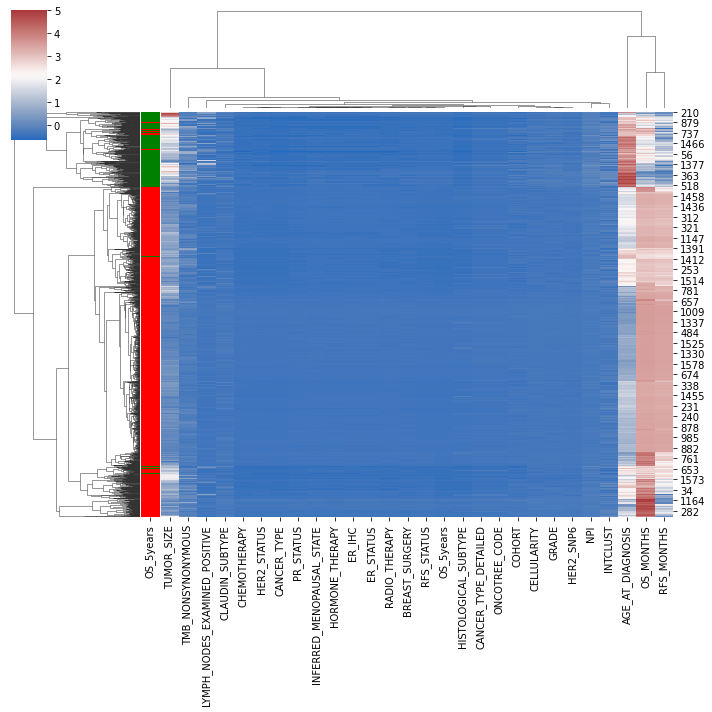

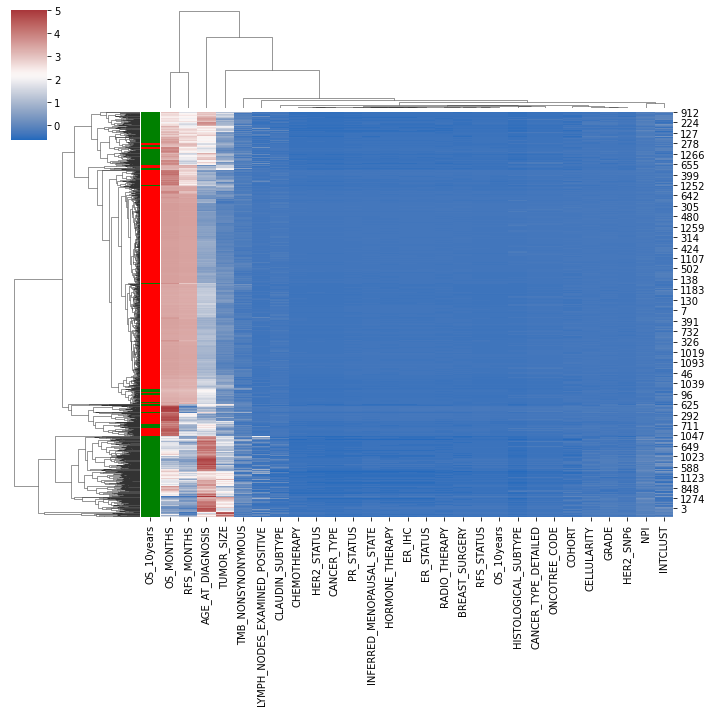

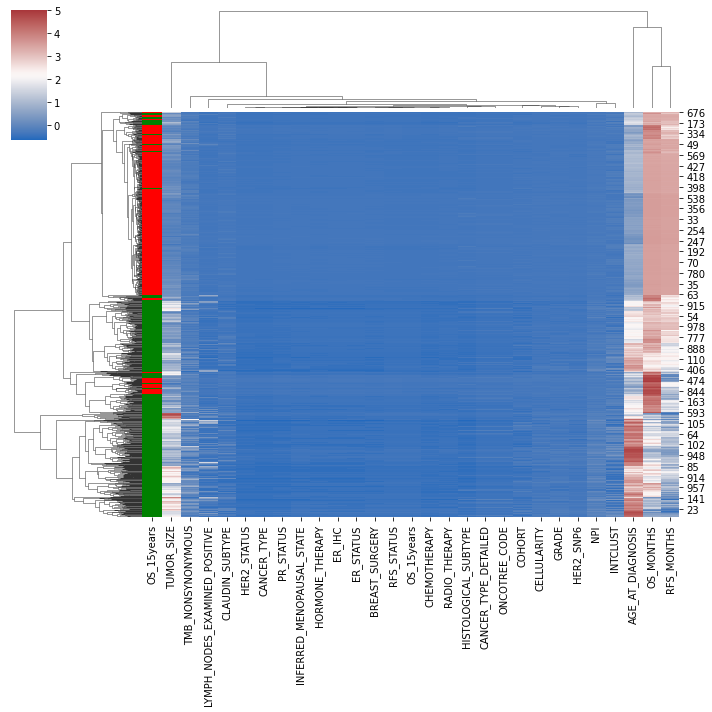

In [154]:
for k in dict_df_os:
    str_target = "OS_" + k.split("_")[2] + "years"
    data = dict_df_os[k].sort_values(str_target)
    data[str_target] = data[str_target].astype(int)
    lut = dict(zip(data[str_target].unique(), "rgb"))
    row_color = data[str_target].map(lut)
    sns.clustermap(
        data=data, figsize=(10, 10), z_score=0, row_colors=row_color, cmap="vlag"
    )

/Users/masanari/.anyenv/envs/pyenv/versions/miniforge3-4.10/envs/breast-cancer-analytics/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/masanari/.anyenv/envs/pyenv/versions/miniforge3-4.10/envs/breast-cancer-analytics/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/Users/masanari/.anyenv/envs/pyenv/versions/miniforge3-4.10/envs/breast-cancer-analytics/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


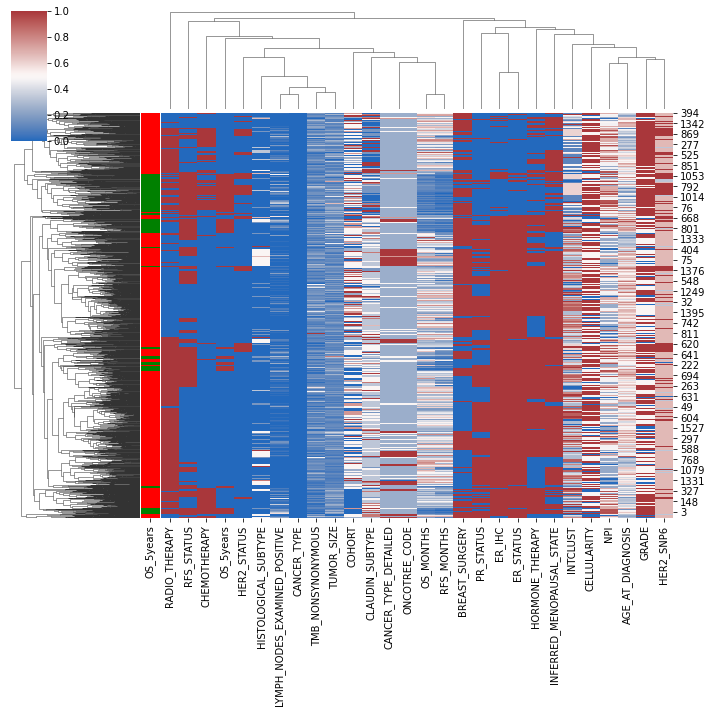

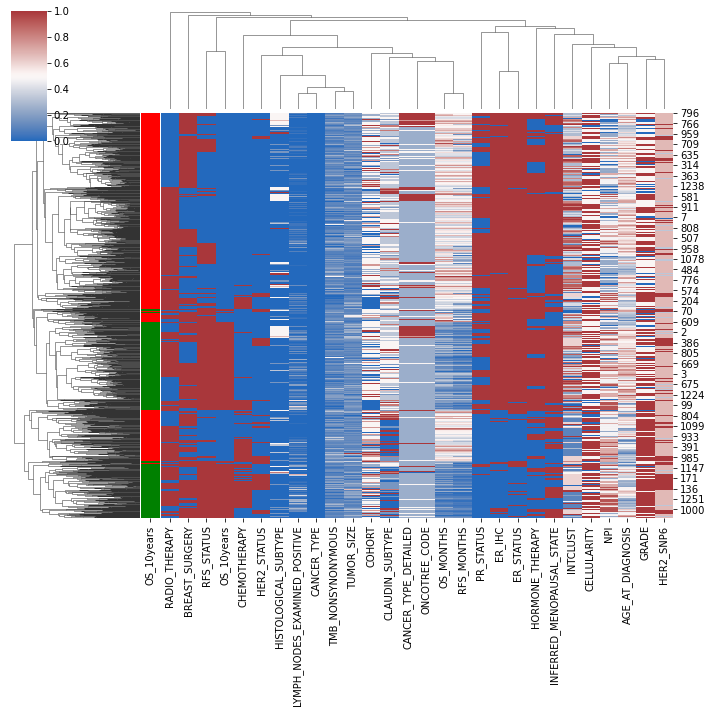

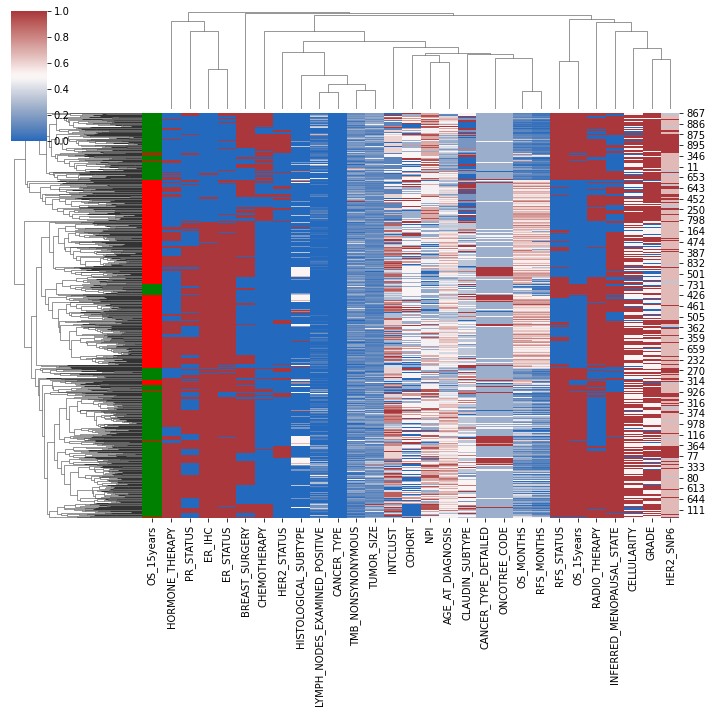

In [151]:
for k in dict_df_os:
    str_target = "OS_" + k.split("_")[2] + "years"
    data = transform_norm(
        dict_df_os[k].sort_values(str_target),
    )
    lut = dict(zip(data[str_target].unique(), "rgb"))
    row_color = data[str_target].map(lut)
    sns.clustermap(data=data, figsize=(10, 10), row_colors=row_color, cmap="vlag")

## 結果
イマイチ見方がわからない・・・  
デンドログラムを元に特徴量を削減できる可能性はあるが、削減することが直接的に遺伝子発現からの予測に影響するわけではないので、デンドログラムに基づいた特徴量削減の効果は疑問。

# 治療間の目的変数の違い
※前処理終了済みデータを使用

In [ ]:
print(df_MB_["CHEMOTHERAPY"].unique())
print(df_MB_["HORMONE_THERAPY"].unique())
print(df_MB_["RADIO_THERAPY"].unique())
print(df_MB_["BREAST_SURGERY"].unique())

In [ ]:
"""
display(df_MB_[df_MB_["CHEMOTHERAPY"].isnull()])
display(df_MB_[df_MB_["HORMONE_THERAPY"].isnull()])
display(df_MB_[df_MB_["RADIO_THERAPY"].isnull()])
display(df_MB_[df_MB_["BREAST_SURGERY"].isnull()])
"""
print(len(df_MB_[df_MB_["CHEMOTHERAPY"].isnull()]))
print(len(df_MB_[df_MB_["HORMONE_THERAPY"].isnull()]))
print(len(df_MB_[df_MB_["RADIO_THERAPY"].isnull()]))
print(len(df_MB_[df_MB_["BREAST_SURGERY"].isnull()]))

以下のindexについては欠損値が多すぎるため、削除したほうが良さそう
- 9
- 221
- 226
- 441
- 1680

BREAST_SURGERYがnullのデータは30件▷欠損と解釈して良さそう（手術していない、などではない）？

## 治療法ごとの患者のデータの観察

### 生存期間（OS）と再発期間（RFS）の同時表示

In [ ]:
def EDA_treatment_RFS(df: pd.DataFrame(), save_path: str = None):
    """
    print(
        "OS_MONTHS - RFS_MONTHS < 1 size: ",
        len(df_tmp[df["OS_MONTHS"] - df["RFS_MONTHS"] < 1]),
    )
    print(
        "OS_MONTHS - RFS_MONTHS < 1 percentage: ",
        round(
            len(df[df["OS_MONTHS"] - df["RFS_MONTHS"] < 1])
            / len(df[df["RFS_STATUS"] == "1:Recurred"]),
            3,
        ),  # 全体に対する比率（丸め誤差下3桁）
    )
    """
    title = "サンプルサイズ: %s, 乳がんによる死亡者割合: %s, 再発者の割合: %s, 平均予後月数: %s, 平均再発月数: %s".format(
        len(df),
        round(
            len(df[df["VITAL_STATUS"] == "Died of Disease"]) / len(df), 3
        ),  # 死亡者の割合（丸め誤差下3桁）
        round(
            len(df[df["RFS_STATUS"] == "1:Recurred"]) / len(df), 3
        ),  # 再発者の占める割合（丸め誤差下3桁）
        round(df_tmp["OS_MONTHS"].mean(), 3),
        round(df_tmp["RFS_MONTHS"].mean(), 3),
    )
    plot = sns.jointplot(
        x="OS_MONTHS",
        y="RFS_MONTHS",
        data=df,
        hue="RFS_STATUS",
        hue_order=["0:Not Recurred", "1:Recurred"],
        xlim=(0, 400),
        ylim=(0, 400),
    )
    plot.set(title=title)
    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()

In [ ]:
dic = {
    "CHEMOTHERAPY": ["YES", "NO"],
    "HORMONE_THERAPY": ["YES", "NO"],
    "RADIO_THERAPY": ["YES", "NO"],
    "BREAST_SURGERY": ["MASTECTOMY", "BREAST CONSERVING"],
}

make_dir("./hoge")

df_tmp = None  # 初期化
prod = [x for x in itertools.product(*dic.values())]
result = [dict(zip(dic.keys(), r)) for r in prod]

for n, r in enumerate(result):
    df_tmp = df_MB_[
        (df_MB["CHEMOTHERAPY"] == r["CHEMOTHERAPY"])
        & (df_MB["HORMONE_THERAPY"] == r["HORMONE_THERAPY"])
        & (df_MB["RADIO_THERAPY"] == r["RADIO_THERAPY"])
        & (df_MB["BREAST_SURGERY"] == r["BREAST_SURGERY"])
    ]
    df_tmp = df_tmp[df_tmp["VITAL_STATUS"] != "Died of Other Causes"]
    print(r)
    save_path = "./hoge/" + str(r) + ".png"
    EDA_treatment_RFS(
        df_tmp,
    )  # save_path)
df_tmp = None  # 初期化

#### 考察

特異的な組み合わせ
- {'HORMONE_THERAPY': 'NO', 'RADIO_THERAPY': 'YES', 'BREAST_SURGERY': 'MASTECTOMY'}
再発している患者の割合が多い


In [ ]:
def EDA_treatment_OS(df: pd.DataFrame()):
    print("sample size (Living, Died of Disease): ", len(df))
    print(
        "Died of Disease sample percentage: ",
        round(
            len(df[df["VITAL_STATUS"] == "Died of Disease"]) / len(df), 3
        ),  # 死亡者の割合（丸め誤差下3桁）
    )
    print(
        "RFS sample percentage: ",
        round(
            len(df[df["RFS_STATUS"] == "1:Recurred"]) / len(df), 3
        ),  # 再発者の占める割合（丸め誤差下3桁）
    )
    sns.set()
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.boxplot(
        x="RFS_STATUS",
        y="OS_MONTHS",
        data=df,
        hue="VITAL_STATUS",
        hue_order=["Living", "Died of Disease"],
    )
    ax.set(ylim=(0, 400))
    plt.show()

In [ ]:
dic = {
    "CHEMOTHERAPY": ["YES", "NO"],
    "HORMONE_THERAPY": ["YES", "NO"],
    "RADIO_THERAPY": ["YES", "NO"],
    "BREAST_SURGERY": ["MASTECTOMY", "BREAST CONSERVING"],
}


df_tmp = None  # 初期化
prod = [x for x in itertools.product(*dic.values())]
result = [dict(zip(dic.keys(), r)) for r in prod]
for r in result:
    df_tmp = df_MB[
        (df_MB["CHEMOTHERAPY"] == r["CHEMOTHERAPY"])
        & (df_MB["HORMONE_THERAPY"] == r["HORMONE_THERAPY"])
        & (df_MB["RADIO_THERAPY"] == r["RADIO_THERAPY"])
        & (df_MB["BREAST_SURGERY"] == r["BREAST_SURGERY"])
    ]
    df_tmp = df_tmp[df_tmp["VITAL_STATUS"] != "Died of Other Causes"]
    print(r)
    EDA_treatment_OS(df_tmp.sort_values("RFS_STATUS"))
df_tmp = None  # 初期化

In [ ]:
! conda install interpret
from interpret import set_visualize_provider

# 生存曲線の観察

lifelinesというライブラリがあったので、試してみる。
https://lifelines.readthedocs.io/en/latest/index.html

In [ ]:
from lifelines import KaplanMeierFitter
from lifelines.utils import concordance_index
from lifelines import KaplanMeierFitter

In [ ]:
# PATIENT_IDにMBを含むデータのみ含むデータフレームを読み込み
df_MB = pd.read_pickle(config.INTERIM_PICKLE_EDA_DIR + "/df_MB.pkl")
df_MB.shape

In [ ]:
T = df_MB["OS_MONTHS"].dropna()
E = (
    df_MB["OS_STATUS"].dropna().map({"0:LIVING": 1, "1:DECEASED": 0})
)  # lifelinesを描くので、生存が1, 死亡が0

kmf = KaplanMeierFitter(label="metabric")
kmf.fit(T, E)
kmf.plot()